### TODO: Remover fundo de imagem e melhorar a visualização para possível reconhecimento individual dos dedos.
### Sugestão: Ou aplicar uma máscara e fazer a diferença entre a mascara e imagem original para remover o fundo, ou usando contornos/bordas.

## Configuração Inicial

Configuração e import de bibliotecas, além da definição da imagem de referência.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

image_path = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg'
imagem = cv2.imread(image_path)
image_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.rcParams['axes.grid'] = False  # Desativa as grades nos plots.

## Primeiras Impressões das Imagens

Vamos plotar a imagem de referência para termos a primeira impressão, e a partir disso, realizar o pré-processamento.

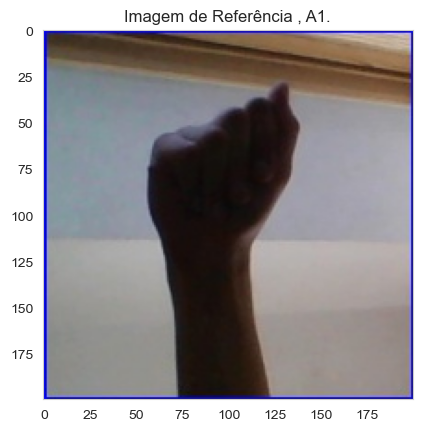

In [47]:
plt.imshow(image_rgb)
plt.title("Imagem de Referência , A1.")
plt.show()

Vamos agora, explorar as propriedades da imagem, como suas dimensões e tipo de encoding.

In [48]:
altura, largura, canais = imagem.shape

propriedades = [
    ('Altura:', altura),
    ('Largura:', largura),
    ('Canais de cor:', canais),
    ('Tipo de dado:', imagem.dtype),
    ('Desvio Padrão', imagem.std())
]

for propriedade, valor_propriedade in propriedades:
    print(f'{propriedade} {valor_propriedade}')


Altura: 200
Largura: 200
Canais de cor: 3
Tipo de dado: uint8
Desvio Padrão 58.922554249836544


Passando para os canais da imagem, vamos usar a função np.asarray(), que irá tabular a imagem em forma numérica, possibilitando a separação de canais.  
Tendo em vista cada canal separado, é possível analisar qual cor possui o maior impacto no elemento desejado da imagem, possibilitando aplicar outras operações.
Abaixo, o código para separação e representação.

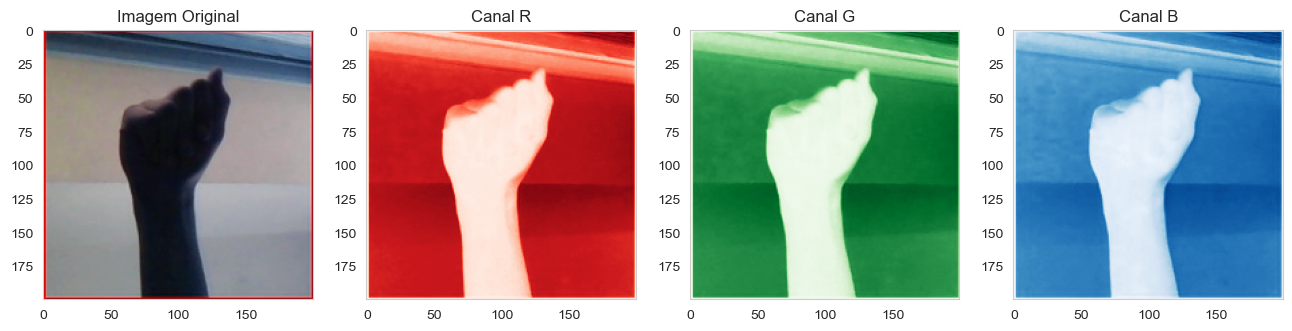

In [49]:
matriz_imagem = np.asarray(imagem)

plt.figure(figsize=(16,8))
plt.subplot(141)

plt.imshow(imagem)
plt.title("Imagem Original")
plt.subplot(142)

plt.imshow(matriz_imagem[:, :, 1], cmap="Reds")
plt.title("Canal R")
plt.subplot(143)

plt.imshow(matriz_imagem[:, :, 1], cmap="Greens")
plt.title("Canal G")
plt.subplot(144)

plt.imshow(matriz_imagem[:, :, 2], cmap="Blues")
plt.title("Canal B")
plt.show()

## Pré-processamento de Imagens

Como os gestos não são dependentes de cores para serem reconhecidos, mas sim dos formatos, vamos converter a imagem para preto e branco.  
Trabalhar com imagens na escala cinza também reduz o custo computacional para realizar processos nas imagems.

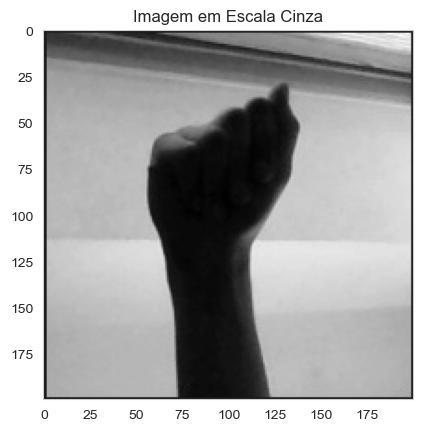

In [50]:
imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)  # Conversão para escala cinza.
plt.imshow(imagem_cinza, cmap="gray")
plt.title("Imagem em Escala Cinza")
plt.show()

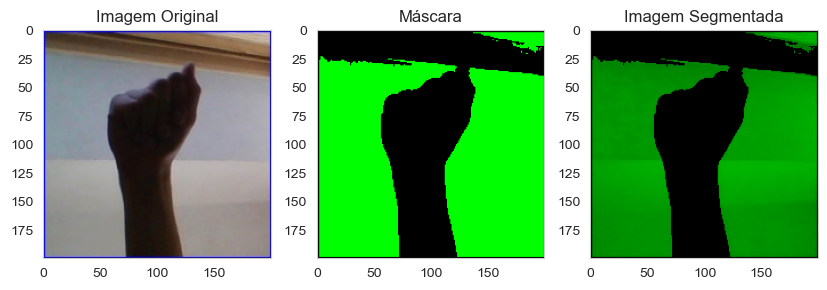

In [52]:
gray_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(imagem)
cv2.drawContours(mask, contours, -1, (0, 255, 0), -1)
segmented_image = cv2.bitwise_and(imagem, mask)

plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(imagem[:, :, ::-1]), plt.title('Imagem Original')
plt.subplot(132), plt.imshow(mask[:, :, ::-1]), plt.title('Máscara')
plt.subplot(133), plt.imshow(segmented_image[:, :, ::-1]), plt.title('Imagem Segmentada')
plt.show()